In [227]:
"""
Author: Zaw
Finding the three most deviations of Predicting the LogP of molecules by using MLP
"""
import numpy as np
import pandas as pd
import math
import time
import os
import sys
import warnings
warnings.simplefilter(action='ignore')
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from hyperopt import fmin,tpe,hp,STATUS_OK, Trials
import pickle
start = time.time()

In [228]:
# Data path
path = os.getcwd()
dirname = os.path.dirname(path)
data_path = dirname+"/LogP/data/extract_data.csv"
col_list=['LogP','Exp_RT']
lc_df = pd.read_csv(data_path,usecols=col_list)
col_smile_list=['SMILES','LogP','Exp_RT']
lc_smiles_df = pd.read_csv(data_path,usecols=col_smile_list)

# Remove non_retained molecules
# index=lc_df[lc_df['Exp_RT'] < 180].index
# lc_df.drop(lc_df[lc_df['Exp_RT'] < 180].index,inplace=True)

# Import descriptor file
path = os.getcwd()
dirname = os.path.dirname(path)
data_path = dirname+"/LogP/data/descriptors.csv"
des_df = pd.read_csv(data_path,index_col=0)

# Remove non_retained molecules
#des_df  = des_df.drop(des_df.index[[index]])
#lc_smiles_df = lc_smiles_df.drop(lc_smiles_df[[index]])
# combine two dataframe
data_comb = pd.concat([lc_smiles_df,des_df],axis=1)

In [229]:
data_comb

,SMILES,LogP,Exp_RT,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CCSC(=N)N,0.67,93.5,6.635046,0.206019,6.635046,0.206019,0.378489,104.178,96.114,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...,2.64,687.8,12.990628,-0.335181,12.990628,0.035905,0.760602,414.333,389.133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Oc1cccc2c(O)nccc12,1.73,583.6,9.356759,-0.052407,9.356759,0.052407,0.617197,161.160,154.104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NCCc1ccc(S(=O)(=O)F)cc1,1.05,653.1,12.386283,-4.565776,12.386283,0.311786,0.740582,203.238,193.158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CNC(=O)c1cc2c(cn1)[nH]c1ccccc12,1.33,705.6,11.531255,-0.169277,11.531255,0.169277,0.665746,225.251,214.163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2066,OCCn1cc(-c2ccc3c(c2)CC/C3=N\O)c(-c2ccncc2)n1,2.05,603.4,9.236427,0.039104,9.236427,0.039104,0.567510,334.379,316.235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2067,CC(C)OC(=O)N1CCC(Oc2ncnc3c2cnn3-c2ccc(S(C)(=O)...,1.59,1061.4,14.683496,-3.539697,14.683496,0.054651,0.550748,477.518,453.326,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2068,CCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(=...,3.73,1059.3,12.960935,-1.190444,12.960935,0.073898,0.724147,402.531,368.259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2069,O=C(c1cc2ccccc2[nH]1)N1CCCC1,1.70,794.3,12.111258,0.133056,12.111258,0.133056,0.777073,214.268,200.156,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [230]:
# # drop the smile column which can not be used for training
# data_comb = data_comb.drop(['SMILES'],axis=1)

# # Filling the nan with mean values in des_with_lc
# for col in data_comb:
#         data_comb[col].fillna(data_comb[col].mean(),inplace=True)
# # Remove features with low Variance(threshold <= 0.05)

# data_var = data_comb.var()
# del_feat = list(data_var[data_var <= 0.05].index)
# data_comb.drop(columns=del_feat, inplace=True)

# # Remove features with correlation(threshold >0.95)
# corr_matrix = data_comb.corr().abs()
# mask = np.triu(np.ones_like(corr_matrix,dtype=bool))
# tri_df = corr_matrix.mask(mask)
# to_drop =  [ c for c in tri_df.columns if any(tri_df[c] > 0.95)]
# data = data_comb.drop(to_drop,axis=1)

In [231]:
# parameters
hidden_layer_sizes_list = [(150,100,50), (120,80,40) ,(100,50,30)]
max_iter_list =[5,10,50,100,200]
activation_list = ['relu', 'tanh', 'logistic']
solver_list = ['sgd','adam']
alpha_list = [0.0001, 0.05]
learning_rate_list =['constant','adaptive']

In [232]:
# The dataset with lc informations
#load the model with lc
path = os.getcwd()
dirname = os.path.dirname(path)

# load the model
file_path = dirname+"/logP/hyperparameters/mlp_lc.pkl"
best_parameters_with_lc = pickle.load(open(file_path,'rb'))

In [233]:
#Single random run with RT
data_set_1 = des_df
data_set_2 = lc_df
des_with_lc = pd.concat([data_set_1,data_set_2],axis=1)
des_with_lc_feat_corr = des_with_lc.columns[des_with_lc.corrwith(des_with_lc['LogP']) >=0.90][:-1]
des_with_lc = des_with_lc.drop(columns=des_with_lc_feat_corr)

# Rescale the feature
def scale(col):
    return (col - np.min(col))/(np.max(col)-np.min(col))

# Filling the nan with mean values in des_with_lc
for col in des_with_lc:
    des_with_lc[col].fillna(des_with_lc[col].mean(),inplace=True)

# Remove columns with zero vlues
des_with_lc = des_with_lc.loc[:,(des_with_lc**2).sum() != 0]
data = des_with_lc.drop(['LogP'],axis=1)

# Remove features with low Variance(threshold<=0.05)
data_var = data.var()
del_feat = list(data_var[data_var <= 0.05].index)
data.drop(columns=del_feat, inplace=True)

# Remove features with correlation(threshold > 0.95)
corr_matrix = data.corr().abs()
mask = np.triu(np.ones_like(corr_matrix,dtype=bool))
tri_df = corr_matrix.mask(mask)
to_drop =  [ c for c in tri_df.columns if any(tri_df[c] > 0.95)]
data = data.drop(to_drop,axis=1)

# Scale the features
cols = list(data)
data[cols] = data[cols].apply(scale,axis=0)
data = pd.concat([data,des_with_lc['LogP']],axis=1)

# Single random run

# data set preparation
train , test = train_test_split(data,train_size = 0.5,shuffle=True)
#validate , test = train_test_split(rest, train_size = 0.5, shuffle=True)

# training set
data_tra_x = train.drop(['LogP'],axis=1)
data_tra_y = train['LogP']

# # validation set
# data_val_x = validate.drop(['LogP'],axis=1)
# data_val_y = validate['LogP']

# test set
data_tes_x = test.drop(['LogP'],axis=1)
data_tes_y = test['LogP']

best_model = MLPRegressor(hidden_layer_sizes = hidden_layer_sizes_list[best_parameters_with_lc['hidden_layer_sizes']],
                            max_iter = max_iter_list[best_parameters_with_lc['max_iter']],
                            activation = activation_list[best_parameters_with_lc['activation']],
                            solver = solver_list[best_parameters_with_lc['solver']],
                            alpha = alpha_list[best_parameters_with_lc['alpha']],
                            learning_rate = learning_rate_list[best_parameters_with_lc['learning_rate']]
                            )

best_model.fit(data_tra_x,data_tra_y)

# training error
tra_pred = best_model.predict(data_tra_x)
tra_results = ['tra',mean_squared_error(data_tra_y,tra_pred),
            mean_squared_error(data_tra_y,tra_pred,squared=False),
            mean_absolute_error(data_tra_y,tra_pred),
            r2_score(data_tra_y,tra_pred)]

# # validation error
# val_pred = best_model.predict(data_val_x)
# val_results = ['val',mean_squared_error(data_val_y,val_pred),
#             mean_squared_error(data_val_y,val_pred,squared=False),
#             mean_absolute_error(data_val_y,val_pred),
#             r2_score(data_val_y,val_pred)]
# testing error
tes_pred = best_model.predict(data_tes_x)
tes_results = ['tes',mean_squared_error(data_tes_y,tes_pred),
            mean_squared_error(data_tes_y,tes_pred,squared=False),
            mean_absolute_error(data_tes_y,tes_pred),
            r2_score(data_tes_y,tes_pred)]


all_set = tra_results,tes_results


all_set_df = pd.DataFrame(all_set,columns=['set','mse','rmse','mae','r2'])
print(all_set_df)
#all_set_df.to_excel(dirname+"/logP/results/mlp_single_rt.xlsx")
# print('\nSingle random run with LC information is done.')

# run_best_model(des_df,lc_df)

   set       mse      rmse       mae        r2
0  tra  0.218677  0.467629  0.346938  0.918317
1  tes  0.286036  0.534823  0.398079  0.905000


In [234]:
# Predictions
predictions = pd.DataFrame(tes_pred,columns=['Predicted LogP'])

data_test = test
data_test['index'] = data_test.index

data_comb_smiles = data_comb
data_comb_smiles['index'] = data_comb_smiles.index

result = pd.merge(data_test['index'],data_comb_smiles)

test_df = result[['SMILES','LogP']]

In [340]:
test_df

,SMILES,LogP
0,CCOC(=O)N1CCN(C(=O)CN2C(=O)c3ccccc3S2(=O)=O)CC1,-0.16
1,CN(C)Cc1cc(C(F)(F)F)ccc1C(O)(c1ccccc1)c1ccccc1,5.46
2,NCCc1nc(-c2ccccc2)cs1,2.10
3,COC[C@@H](c1ccc(C(F)(F)F)cc1)N1CCN(C2(C)CCN(C(...,2.80
4,Nn1c(Cc2ccccc2)nnc1Cc1ccccc1,1.84
...,...,...
1031,Cc1ccccc1/C=C/C1=NCCN1,2.24
1032,CCCCCCCCN[C@H](C)[C@@H](O)c1ccc(SC(C)C)cc1,5.61
1033,c1ccc(-c2cn3c(n2)SCC3)cc1,2.99
1034,O=C(NC1CCOCC1)c1ccc(-c2cc(-c3c[nH]nc3-c3ccccn3...,2.98


In [236]:
# create dataframe with predicted LogP and Experimenatal logP
predictions = pd.DataFrame(tes_pred,columns=['Predicted LogP'])

mlp_df = pd.concat([test_df,predictions],axis=1)

mlp_df.rename(columns={'LogP':'Experimental LogP'},inplace=True)

mlp_df['Predicted LogP'] = mlp_df['Predicted LogP'].round(decimals=2)


In [237]:
mlp_df

,SMILES,Experimental LogP,Predicted LogP
0,CCOC(=O)N1CCN(C(=O)CN2C(=O)c3ccccc3S2(=O)=O)CC1,-0.16,-0.47
1,CN(C)Cc1cc(C(F)(F)F)ccc1C(O)(c1ccccc1)c1ccccc1,5.46,5.21
2,NCCc1nc(-c2ccccc2)cs1,2.10,2.23
3,COC[C@@H](c1ccc(C(F)(F)F)cc1)N1CCN(C2(C)CCN(C(...,2.80,3.89
4,Nn1c(Cc2ccccc2)nnc1Cc1ccccc1,1.84,2.39
...,...,...,...
1031,Cc1ccccc1/C=C/C1=NCCN1,2.24,2.22
1032,CCCCCCCCN[C@H](C)[C@@H](O)c1ccc(SC(C)C)cc1,5.61,5.60
1033,c1ccc(-c2cn3c(n2)SCC3)cc1,2.99,2.10
1034,O=C(NC1CCOCC1)c1ccc(-c2cc(-c3c[nH]nc3-c3ccccn3...,2.98,2.88


In [243]:
# Find deviation
mlp_df['Deviation'] = (mlp_df['Experimental LogP']- mlp_df['Predicted LogP'])

In [244]:
# round off decimal value
mlp_df['Deviation'] = mlp_df['Deviation'].round(decimals=2)

In [245]:
mlp_df

,SMILES,Experimental LogP,Predicted LogP,Deviation
0,CCOC(=O)N1CCN(C(=O)CN2C(=O)c3ccccc3S2(=O)=O)CC1,-0.16,-0.47,0.31
1,CN(C)Cc1cc(C(F)(F)F)ccc1C(O)(c1ccccc1)c1ccccc1,5.46,5.21,0.25
2,NCCc1nc(-c2ccccc2)cs1,2.10,2.23,-0.13
3,COC[C@@H](c1ccc(C(F)(F)F)cc1)N1CCN(C2(C)CCN(C(...,2.80,3.89,-1.09
4,Nn1c(Cc2ccccc2)nnc1Cc1ccccc1,1.84,2.39,-0.55
...,...,...,...,...
1031,Cc1ccccc1/C=C/C1=NCCN1,2.24,2.22,0.02
1032,CCCCCCCCN[C@H](C)[C@@H](O)c1ccc(SC(C)C)cc1,5.61,5.60,0.01
1033,c1ccc(-c2cn3c(n2)SCC3)cc1,2.99,2.10,0.89
1034,O=C(NC1CCOCC1)c1ccc(-c2cc(-c3c[nH]nc3-c3ccccn3...,2.98,2.88,0.10


In [246]:
# dataframe to csv
mlp_df.to_csv('mlp_exp_pre.csv')

#### The three most deviation values

In [339]:
data_tes_y

1736   -0.16
345     5.46
1847    2.10
498     2.80
1675    1.84
        ... 
1051    2.24
1181    5.61
784     2.99
1698    2.98
91      2.62
Name: LogP, Length: 1036, dtype: float64

In [250]:
# The three most deviation values
mlp_df.iloc[list(mlp_df['Deviation'].nlargest(3).index)]

,SMILES,Experimental LogP,Predicted LogP,Deviation
540,O=C(O)CCn1nnc2ccccc2c1=O,1.73,-0.26,1.99
309,O=[N+]([O-])c1cn2c(n1)OC[C@@H](OCc1ccc(OC(F)(F...,4.14,2.28,1.86
899,CCCCN(CC)c1nc(C)nc2c1c(C)cn2-c1c(C)cc(C)cc1C,7.36,5.53,1.83


In [252]:
mlp_df.index[309]

309

In [258]:
mlp_df[mlp_df['Deviation']==1.86]['SMILES'].item()

'O=[N+]([O-])c1cn2c(n1)OC[C@@H](OCc1ccc(OC(F)(F)F)cc1)C2'

#### SMILES to IUPAC name

In [265]:
import pubchempy

smiles ='O=C(O)CCn1nnc2ccccc2c1=O'
compounds = pubchempy.get_compounds(smiles, namespace='smiles')
match = compounds[0]
print(match.iupac_name)

3-(4-oxo-1,2,3-benzotriazin-3-yl)propanoic acid


In [648]:
smiles = [
    'O=C(O)CCn1nnc2ccccc2c1=O',    
]

mols = [Chem.MolFromSmiles(smi) for smi in smiles]


Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(500, 500))
cairosvg.svg2png( url='./temp.svg', write_to= "svg_"+fname+"png" )
plt.savefig('top1.png',dpi=300,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [264]:
smiles ='O=[N+]([O-])c1cn2c(n1)OC[C@@H](OCc1ccc(OC(F)(F)F)cc1)C2'
compounds = pubchempy.get_compounds(smiles, namespace='smiles')
match = compounds[0]
print(match.iupac_name)

(6S)-2-nitro-6-[[4-(trifluoromethoxy)phenyl]methoxy]-6,7-dihydro-5H-imidazo[2,1-b][1,3]oxazine


In [266]:
smiles ='CCCCN(CC)c1nc(C)nc2c1c(C)cn2-c1c(C)cc(C)cc1C'
compounds = pubchempy.get_compounds(smiles, namespace='smiles')
match = compounds[0]
print(match.iupac_name)

N-butyl-N-ethyl-2,5-dimethyl-7-(2,4,6-trimethylphenyl)pyrrolo[2,3-d]pyrimidin-4-amine


#### Display molecules

In [292]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D
import cairosvg
import io

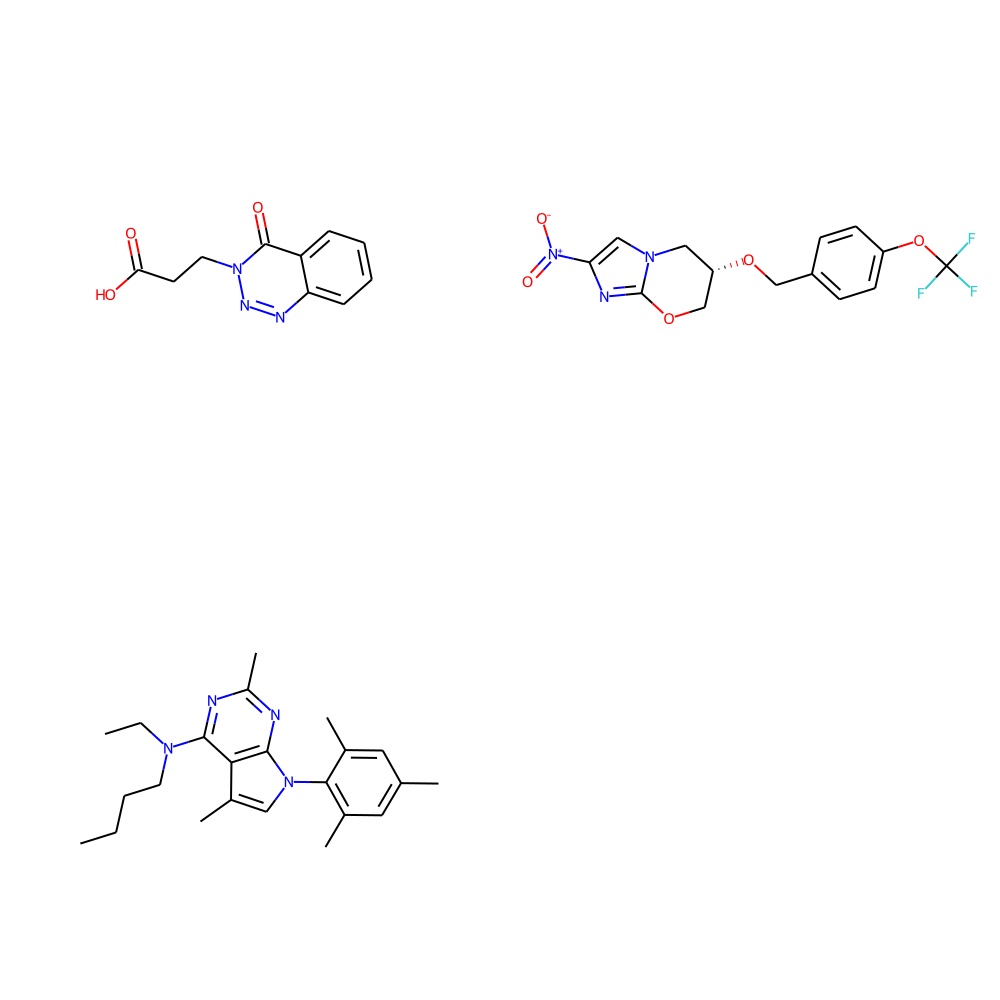

In [298]:
smiles = [
    'O=C(O)CCn1nnc2ccccc2c1=O',
    'O=[N+]([O-])c1cn2c(n1)OC[C@@H](OCc1ccc(OC(F)(F)F)cc1)C2',
    'CCCCN(CC)c1nc(C)nc2c1c(C)cn2-c1c(C)cc(C)cc1C'    
]

mols = [Chem.MolFromSmiles(smi) for smi in smiles]


Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(500, 500))

In [294]:
mols

#### Smallest deviation

In [336]:
mlp_df_copy = mlp_df
mlp_df_copy['Deviation'] = mlp_df_copy['Deviation'].abs()

In [337]:
# The three most deviation values
mlp_df_copy.iloc[list(mlp_df_copy['Deviation'].nsmallest(10).index)]

,SMILES,Experimental LogP,Predicted LogP,Deviation
282,CCCCCOC(=O)c1ccc(Nc2nc(C(=O)OCC)nc3ccccc23)cc1,5.80,5.80,0.0
351,Cc1ccccc1Nc1c(-c2ccccc2)nc2cccc(C)n12,5.03,5.03,0.0
358,Cc1cccc(-c2[nH]c(C(C)(C)C)nc2-c2ccc3nccnc3c2)n1,4.00,4.00,0.0
398,O=C(CCCN1C(=O)c2cccc3cccc(c23)C1=O)N1CCN(c2ccc...,3.29,3.29,0.0
423,CC1=CC(=O)C2=C(C)C[C@H](O)[C@H]3[C@H](C)C(=O)O...,1.12,1.12,0.0
444,CCOC(=O)CC(=O)N1CCS[C@@H]1COc1ccccc1OC,1.86,1.86,0.0
466,O=C1c2ccccc2C(=O)c2nc(-c3ccccc3)c(-c3ccccc3)nc21,5.32,5.32,0.0
560,O=C(c1ccc(CS(=O)(=O)c2ccc(Br)cc2)o1)N1CCN(c2cc...,2.85,2.85,0.0
593,Cc1cc(C)n2nc(SCC(=O)Nc3ccc(F)cc3)nc2n1,2.59,2.59,0.0
608,Oc1ccnc(Nc2ccc(Cl)cc2)n1,3.06,3.06,0.0


In [358]:
mlp_df_copy[mlp_df_copy['Experimental LogP']==mlp_df_copy['Predicted LogP']]

,SMILES,Experimental LogP,Predicted LogP,Deviation
282,CCCCCOC(=O)c1ccc(Nc2nc(C(=O)OCC)nc3ccccc23)cc1,5.80,5.80,0.0
351,Cc1ccccc1Nc1c(-c2ccccc2)nc2cccc(C)n12,5.03,5.03,0.0
358,Cc1cccc(-c2[nH]c(C(C)(C)C)nc2-c2ccc3nccnc3c2)n1,4.00,4.00,0.0
398,O=C(CCCN1C(=O)c2cccc3cccc(c23)C1=O)N1CCN(c2ccc...,3.29,3.29,0.0
423,CC1=CC(=O)C2=C(C)C[C@H](O)[C@H]3[C@H](C)C(=O)O...,1.12,1.12,0.0
444,CCOC(=O)CC(=O)N1CCS[C@@H]1COc1ccccc1OC,1.86,1.86,0.0
466,O=C1c2ccccc2C(=O)c2nc(-c3ccccc3)c(-c3ccccc3)nc21,5.32,5.32,0.0
560,O=C(c1ccc(CS(=O)(=O)c2ccc(Br)cc2)o1)N1CCN(c2cc...,2.85,2.85,0.0
593,Cc1cc(C)n2nc(SCC(=O)Nc3ccc(F)cc3)nc2n1,2.59,2.59,0.0
608,Oc1ccnc(Nc2ccc(Cl)cc2)n1,3.06,3.06,0.0


In [642]:
mlp_df_copy[mlp_df_copy['Deviation']==0.02]

,SMILES,Experimental LogP,Predicted LogP,Deviation
27,Cn1c(=O)c2c(ncn2CC2OCCO2)n(C)c1=O,-0.49,-0.47,0.02
47,CN(C)CCN1C(=O)c2cccc3cc(N)cc(c23)C1=O,1.10,1.08,0.02
158,O=S(=O)(c1cccs1)N1CCN(c2ncccn2)CC1,1.47,1.49,0.02
183,CN1[C@H]2CC[C@@H]1C[C@@H](OC(=O)[C@H](CO)c1ccc...,1.57,1.59,0.02
199,CN(C)[C@@H](CCOc1cccc2ccccc12)c1ccccc1,4.67,4.69,0.02
245,CC1(C)Oc2ccc(C#N)cc2[C@@H](OC2=CC(=O)CC2)[C@@H]1O,1.71,1.69,0.02
264,CCOC(=O)C1CCN(c2ncnc3c2cnn3-c2ccccc2)CC1,2.80,2.78,0.02
293,Cc1cccn2c(=O)c3cc(C(=O)NCCc4ccc(S(N)(=O)=O)cc4...,1.22,1.20,0.02
406,CN(C)CC/C=C1/c2ccccc2COc2ccccc21,3.84,3.82,0.02
456,CCN(C(=O)c1ccccc1)c1nc(-c2ccccc2)cs1,4.66,4.68,0.02


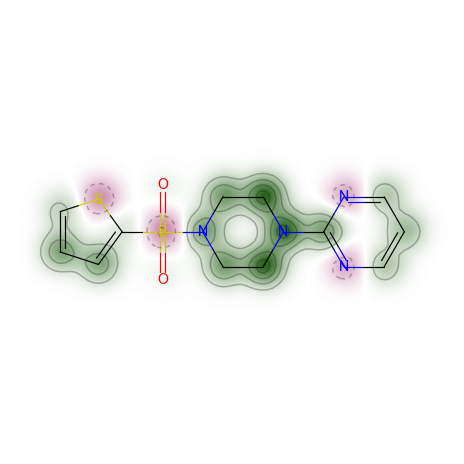

In [646]:
import matplotlib.pyplot as plt
mol = Chem.MolFromSmiles('O=S(=O)(c1cccs1)N1CCN(c2ncccn2)CC1')
refmol = Chem.MolFromSmiles('O=C(CCCN1C(=O)c2cccc3cccc(c23)C1=O)N1CCN(c2ccccc2)CC1')
fp = SimilarityMaps.GetMorganFingerprint(mol, fpType='bv')
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint,contourLines=7,alpha=0.3)
# plt.tight_layout()
plt.savefig('sm2.png',dpi=300,bbox_inches='tight')

In [600]:
mlp_df_copy.iloc[683]['SMILES']

'O=C(CCCN1C(=O)c2cccc3cccc(c23)C1=O)N1CCN(c2ncccn2)CC1'

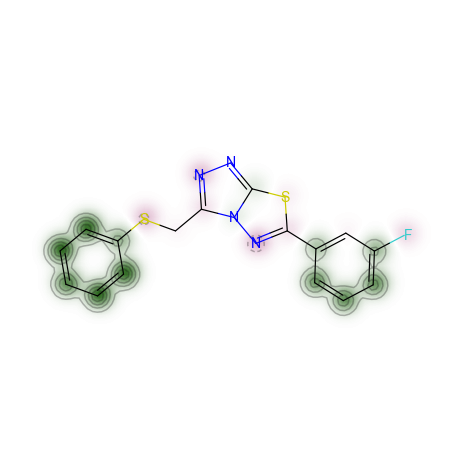

In [631]:
# 4,8
import matplotlib.pyplot as plt
mol = Chem.MolFromSmiles('Fc1cccc(-c2nn3c(CSc4ccccc4)nnc3s2)c1')
refmol = Chem.MolFromSmiles('O=C(CCCN1C(=O)c2cccc3cccc(c23)C1=O)N1CCN(c2ccccc2)CC1')
fp = SimilarityMaps.GetMorganFingerprint(mol, fpType='bv')
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint,contourLines=7,alpha=0.3)
plt.tight_layout()
plt.savefig('sm1.png',dpi=300,bbox_inches='tight')

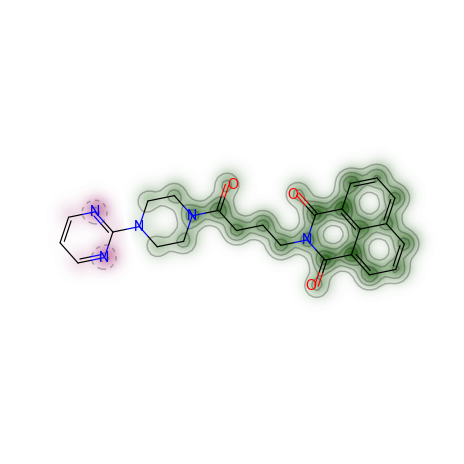

In [632]:
# 4,8
mol = Chem.MolFromSmiles('O=C(CCCN1C(=O)c2cccc3cccc(c23)C1=O)N1CCN(c2ncccn2)CC1')
refmol = Chem.MolFromSmiles('O=C(CCCN1C(=O)c2cccc3cccc(c23)C1=O)N1CCN(c2ccccc2)CC1')
fp = SimilarityMaps.GetMorganFingerprint(mol, fpType='bv')
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint,contourLines=7,alpha=0.3)
plt.savefig('sm2.png',dpi=300,bbox_inches='tight')

In [368]:
mlp_df_copy.iloc[560]['SMILES']

'O=C(c1ccc(CS(=O)(=O)c2ccc(Br)cc2)o1)N1CCN(c2ccccn2)CC1'

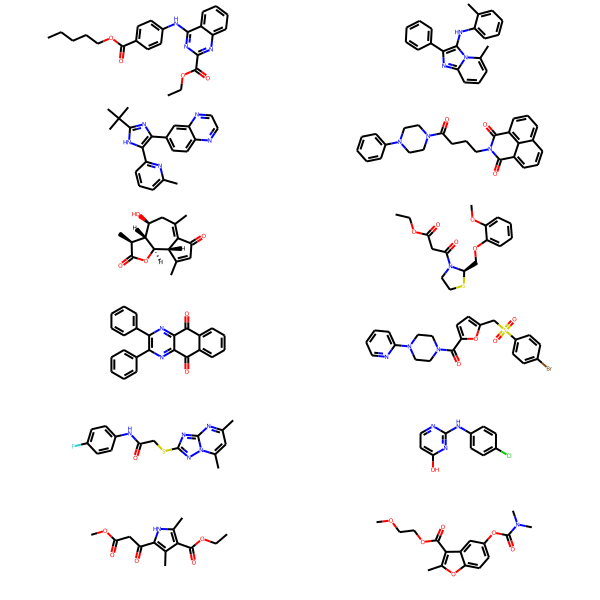

In [372]:
smiles = [
    'CCCCCOC(=O)c1ccc(Nc2nc(C(=O)OCC)nc3ccccc23)cc1',
    'Cc1ccccc1Nc1c(-c2ccccc2)nc2cccc(C)n12',
     'Cc1cccc(-c2[nH]c(C(C)(C)C)nc2-c2ccc3nccnc3c2)n1',
     'O=C(CCCN1C(=O)c2cccc3cccc(c23)C1=O)N1CCN(c2ccccc2)CC1',
     'CC1=CC(=O)C2=C(C)C[C@H](O)[C@H]3[C@H](C)C(=O)O[C@@H]3[C@@H]12',
     'CCOC(=O)CC(=O)N1CCS[C@@H]1COc1ccccc1OC',
     'O=C1c2ccccc2C(=O)c2nc(-c3ccccc3)c(-c3ccccc3)nc21',
     'O=C(c1ccc(CS(=O)(=O)c2ccc(Br)cc2)o1)N1CCN(c2ccccn2)CC1',
     'Cc1cc(C)n2nc(SCC(=O)Nc3ccc(F)cc3)nc2n1',
     'Oc1ccnc(Nc2ccc(Cl)cc2)n1',
     'CCOC(=O)c1c(C)[nH]c(C(=O)CC(=O)OC)c1C',
     'COCCOC(=O)c1c(C)oc2ccc(OC(=O)N(C)C)cc12'
]

mols = [Chem.MolFromSmiles(smi) for smi in smiles]


Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(300, 100))

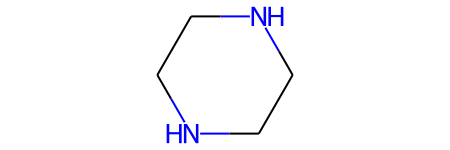

In [540]:
mol = Chem.MolFromSmiles('C1CNCCN1')
mol

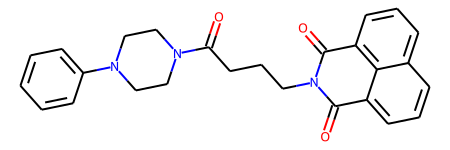

In [635]:
refmol = Chem.MolFromSmiles('O=C(CCCN1C(=O)c2cccc3cccc(c23)C1=O)N1CCN(c2ccccc2)CC1')
refmol

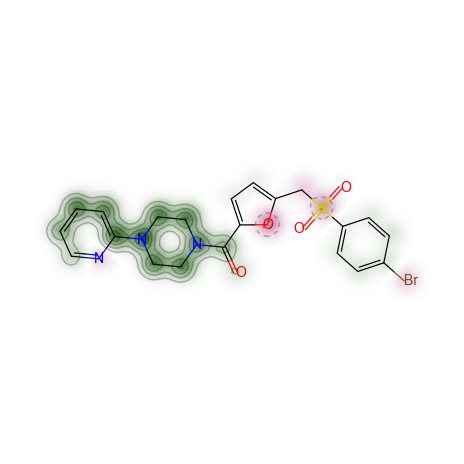

In [633]:
# 4,8
mol = Chem.MolFromSmiles('O=C(c1ccc(CS(=O)(=O)c2ccc(Br)cc2)o1)N1CCN(c2ccccn2)CC1')
refmol = Chem.MolFromSmiles('O=C(CCCN1C(=O)c2cccc3cccc(c23)C1=O)N1CCN(c2ccccc2)CC1')
fp = SimilarityMaps.GetMorganFingerprint(mol, fpType='bv')
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint,contourLines=7,alpha=0.3)
plt.savefig('sm3.png',dpi=300,bbox_inches='tight')

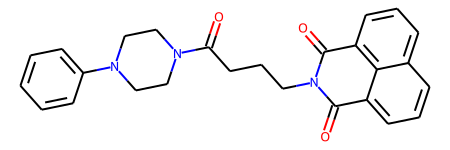

In [550]:
refmol

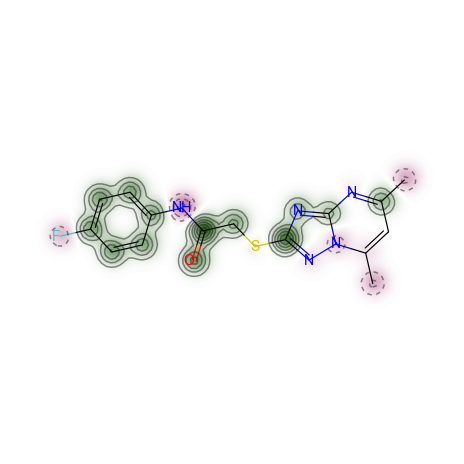

In [549]:
# 4,9
mol = Chem.MolFromSmiles('Cc1cc(C)n2nc(SCC(=O)Nc3ccc(F)cc3)nc2n1')
refmol = Chem.MolFromSmiles('O=C(CCCN1C(=O)c2cccc3cccc(c23)C1=O)N1CCN(c2ccccc2)CC1')
fp = SimilarityMaps.GetMorganFingerprint(mol, fpType='bv')
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint)

In [400]:
rdMolDescriptors.PEOE_VSA_(mol)

[19.370712225710204,
 19.662403956816714,
 0.0,
 0.0,
 0.0,
 18.19910120538483,
 43.651867925611036,
 50.50369338725382,
 18.313884533577358,
 5.516700717616262,
 17.09277939380059,
 0.0,
 5.907179729351506,
 0.0]

In [402]:
from rdkit.Chem import Descriptors
Descriptors.MolLogP(mol)

3.7168000000000028

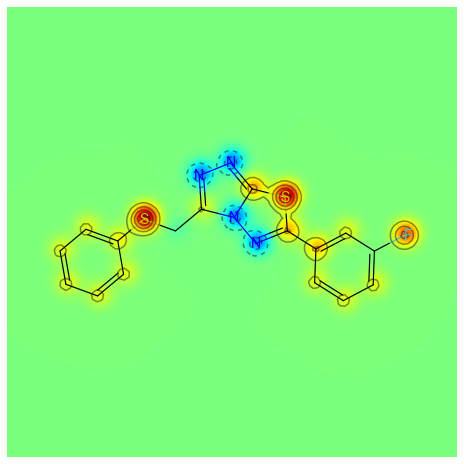

In [615]:
from rdkit.Chem import rdMolDescriptors
contribs = rdMolDescriptors._CalcCrippenContribs(mol)
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol,[x for x,y in contribs], colorMap='jet', contourLines=7)

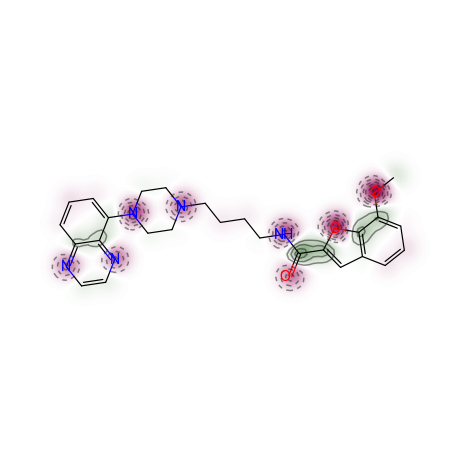

In [608]:
from rdkit.Chem.Draw import SimilarityMaps
mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
AllChem.ComputeGasteigerCharges(mol)
contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, contourLines=10)

In [412]:
AllChem.ComputeGasteigerCharges(mol)

In [411]:
AllChem.PEOE_VSA_(mol)

[19.370712225710204,
 19.662403956816714,
 0.0,
 0.0,
 0.0,
 18.19910120538483,
 43.651867925611036,
 50.50369338725382,
 18.313884533577358,
 5.516700717616262,
 17.09277939380059,
 0.0,
 5.907179729351506,
 0.0]

In [428]:
# from list to dataframe
smiles_df = pd.DataFrame(smiles,columns=['SMILES'])

In [432]:
smiles_df.to_csv("smiles.csv")

#### Tanimoto similarities

In [433]:
# import libraries
import time
import random
import sys
from pathlib import Path
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import SimilarityMaps

In [434]:
# show full results
np.set_printoptions(threshold=sys.maxsize)

In [435]:
# Reading the input CSV file.

ligands_df = pd.read_csv("smiles.csv" , index_col=0 )
print(ligands_df.head())

                                              SMILES
0     CCCCCOC(=O)c1ccc(Nc2nc(C(=O)OCC)nc3ccccc23)cc1
1              Cc1ccccc1Nc1c(-c2ccccc2)nc2cccc(C)n12
2    Cc1cccc(-c2[nH]c(C(C)(C)C)nc2-c2ccc3nccnc3c2)n1
3  O=C(CCCN1C(=O)c2cccc3cccc(c23)C1=O)N1CCN(c2ccc...
4  CC1=CC(=O)C2=C(C)C[C@H](O)[C@H]3[C@H](C)C(=O)O...


In [436]:
# Creating molecules and storing in an array
molecules = []

"""Let's fetch the smiles from the input file and store in molecules array
        We have used '_' because we don't want any other column.
        If you want to fetch index and any other column, then replace '_' with 
            index and write column names after a ','.
"""

for _, smiles in ligands_df[[ "SMILES"]].itertuples():
    molecules.append((Chem.MolFromSmiles(smiles)))
molecules[:15]

In [437]:
# Creating fingerprints for all molecules

rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=7)
fgrps = [rdkit_gen.GetFingerprint(mol) for mol in molecules]

In [438]:
# Calculating number of fingerprints
nfgrps = len(fgrps)
print("Number of fingerprints:", nfgrps)


Number of fingerprints: 12


In [439]:
# Defining a function to calculate similarities among the molecules
def pairwise_similarity(fingerprints_list):
    
    global similarities

    similarities = np.zeros((nfgrps, nfgrps))

    for i in range(1, nfgrps):
            similarity = DataStructs.BulkTanimotoSimilarity(fgrps[i], fgrps[:i])
            similarities[i, :i] = similarity
            similarities[:i, i] = similarity

    return similarities

In [440]:
# Calculating similarities of molecules
pairwise_similarity(fgrps)
tri_lower_diag = np.tril(similarities, k=0)

In [445]:
# Visulaizing the similarities

# definging labels to show on heatmap
labels = ['lig1','lig2','lig3','lig4','lig5','lig6','lig7', 'lig8', 'lig9', 'lig10', 'lig11', 'lig12']



def normal_heatmap (sim):

    # writing similalrities to a file
    f = open("similarities.txt", "w")
    print (similarities, file=f)

    sns.set(font_scale=0.8)

    # generating the plot
    
    plot = sns.heatmap(sim[:15,:15], annot = True, annot_kws={"fontsize":5}, center=0,
            square=True, xticklabels=labels, yticklabels=labels, linewidths=.7, cbar_kws={"shrink": .5})

    plt.title('Heatmap of Tanimoto Similarities', fontsize = 20) # title with fontsize 20

    plt.show()

    # saving the plot

    fig = plot.get_figure()
    fig.savefig("tanimoto_heatmap.png") 


def lower_tri_heatmap (sim):
    f = open("similarities_lower_tri.txt", "w")

    print (tri_lower_diag, file=f)

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    lower_tri_plot = sns.heatmap(tri_lower_diag[:15,:15], annot = False, cmap=cmap,center=0,
            square=True, xticklabels=labels, yticklabels=labels, linewidths=.7, cbar_kws={"shrink": .5})

    plt.title('Heatmap of Tanimoto Similarities', fontsize = 20)

    plt.show()

    fig = lower_tri_plot.get_figure()
    fig.savefig("tanimoto_heatmap_lw_tri.png") 

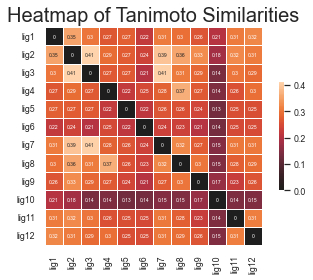

In [446]:
normal_heatmap(similarities)

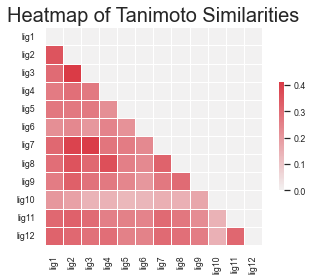

In [447]:
lower_tri_heatmap(similarities)